In [52]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import os
import sys

parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
# MPC import
from LinearMPC_3_3.MPCVelControl import MPCVelControl
from PIControl.PIControl import PIControl
import numpy as np
from src.rocket import Rocket
from src.vel_rocket_vis import RocketVis
import matplotlib.pyplot as plt

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

In [54]:
Ts = 0.05
sim_time = 20
H = 5.0
x0 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 50, 50, 100])  # initial state
pos_target = np.array([0, 0, 10.0])

rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
pos_controller = PIControl(pos_target)
mpc = MPCVelControl().new_controller(rocket, Ts, H)

t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, ref = rocket.simulate_control(
    mpc, sim_time, H, x0, pos_control=pos_controller, method="linear"
)

vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 0.1
vis.animate(
    t_cl[:-1],
    x_cl[:, :-1],
    u_cl,
    Ref=ref[:, :-1],
    T_ol=t_ol[..., :-1],
    X_ol=x_ol,
    U_ol=u_ol,
);

# Print final position
final_pos = x_cl[9:12, -1]  # x, y, z positions (indices 9, 10, 11)
print(f"\n{'='*60}")
print(f"Final Rocket Position:")
print(f"  x = {final_pos[0]:.4f} m")
print(f"  y = {final_pos[1]:.4f} m")
print(f"  z = {final_pos[2]:.4f} m")
print(f"  Target position: [{pos_target[0]:.4f}, {pos_target[1]:.4f}, {pos_target[2]:.4f}] m")
print(f"  Position error: {np.linalg.norm(final_pos - pos_target):.4f} m")
print(f"{'='*60}")



Simulating time 0.00: 
Simulating time 0.05: 
Simulating time 0.10: 
Simulating time 0.15: 
Simulating time 0.20: 
Simulating time 0.25: 
 State beta violation: -0.19 < -0.17, 
 State alpha violation: 0.19 > 0.17, 
Simulating time 0.30: 
 State beta violation: -0.20 < -0.17, 
 State alpha violation: 0.20 > 0.17, 
Simulating time 0.35: 
 State beta violation: -0.20 < -0.17, 
 State alpha violation: 0.20 > 0.17, 
Simulating time 0.40: 
 State beta violation: -0.19 < -0.17, 
 State alpha violation: 0.19 > 0.17, 
Simulating time 0.45: 
 State beta violation: -0.19 < -0.17, 
 State alpha violation: 0.19 > 0.17, 
Simulating time 0.50: 
 State beta violation: -0.18 < -0.17, 
 State alpha violation: 0.18 > 0.17, 
Simulating time 0.55: 
 State beta violation: -0.18 < -0.17, 
 State alpha violation: 0.18 > 0.17, 
Simulating time 0.60: 
 State beta violation: -0.18 < -0.17, 
 State alpha violation: 0.18 > 0.17, 
Simulating time 0.65: 
Simulating time 0.70: 
Simulating time 0.75: 
Simulating time 

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', interval=500, max=399), IntSlider(v…


Final Rocket Position:
  x = 0.4230 m
  y = 0.4230 m
  z = 9.4604 m
  Target position: [0.0000, 0.0000, 10.0000] m
  Position error: 0.8057 m


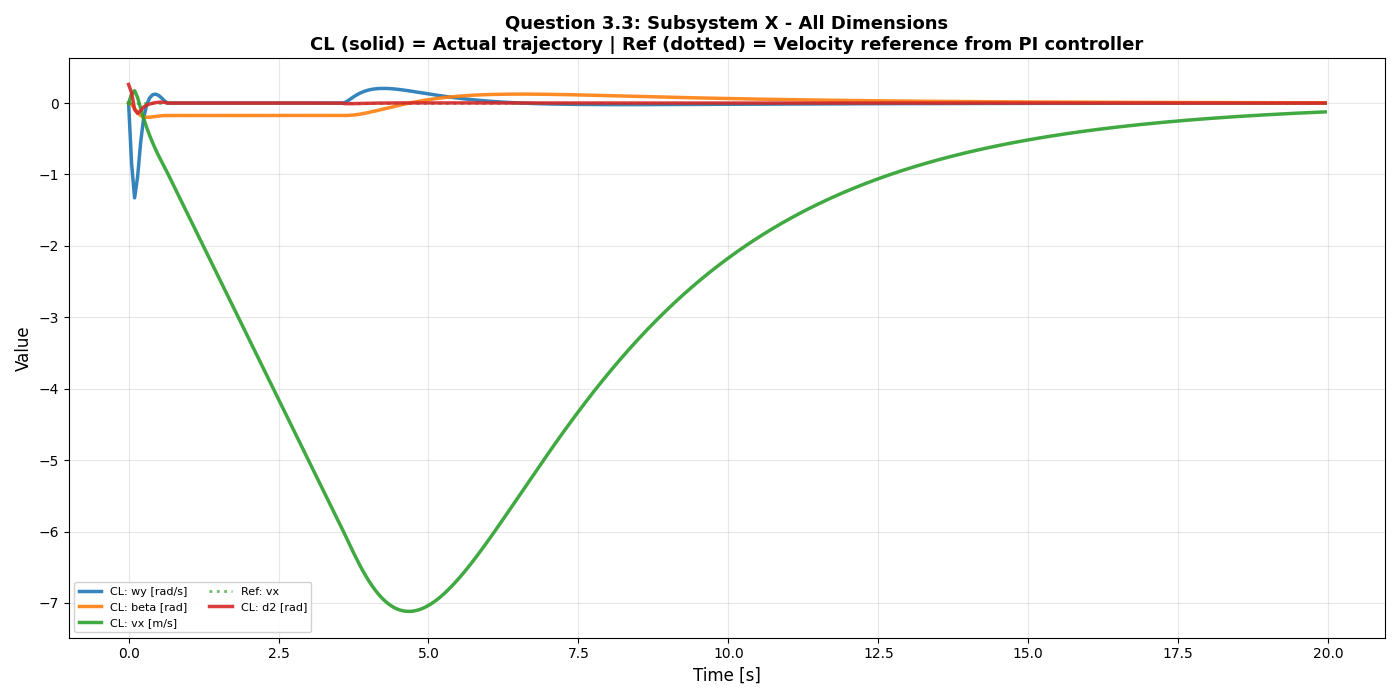

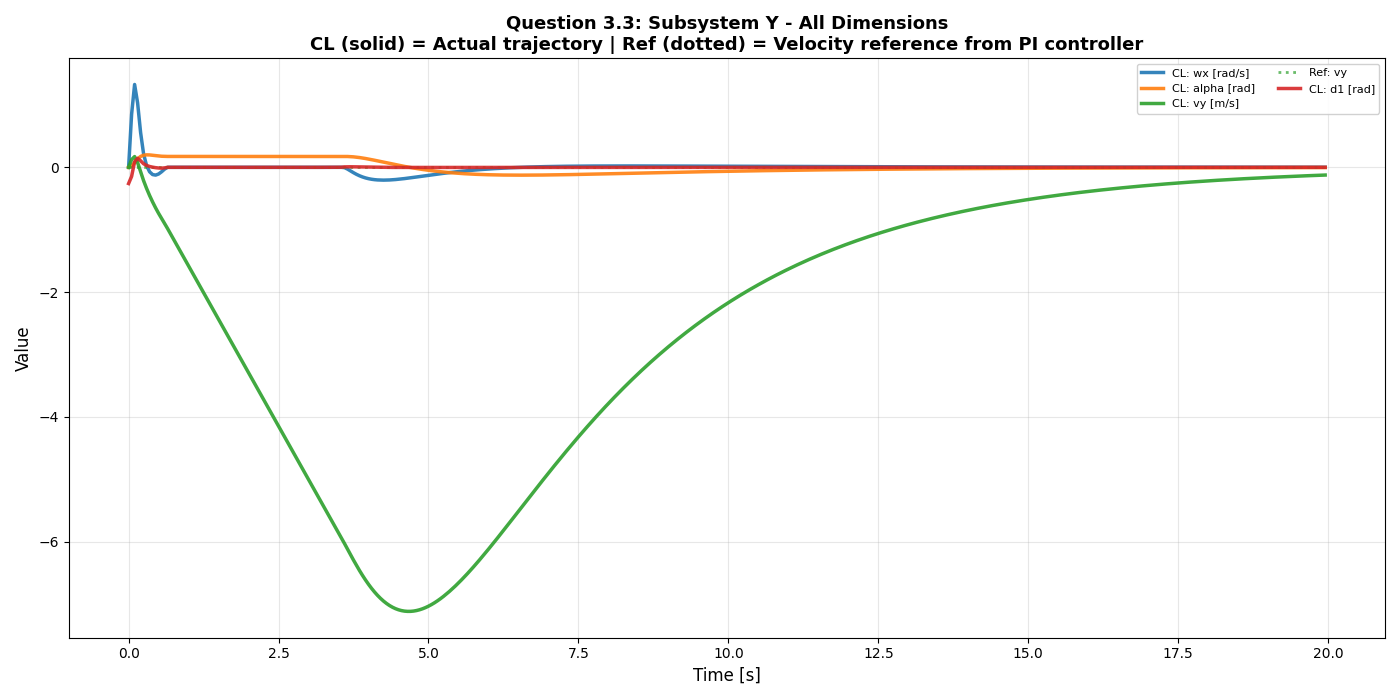

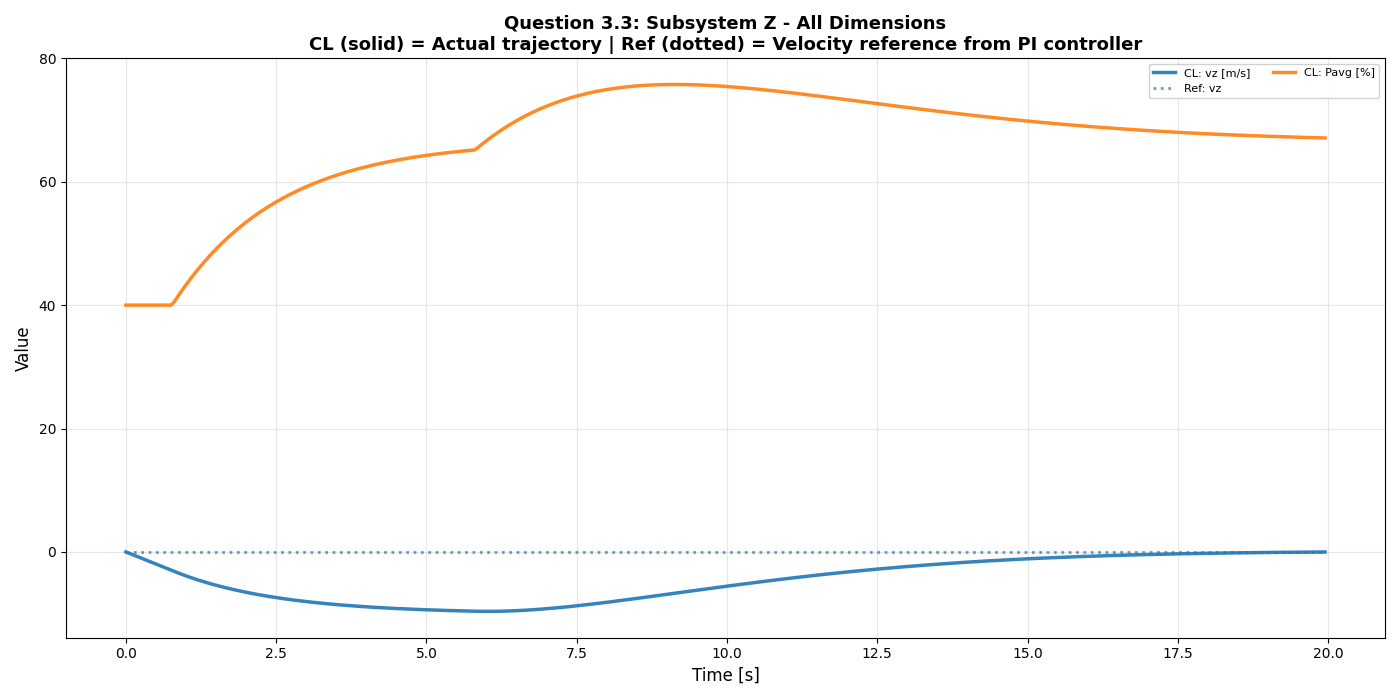

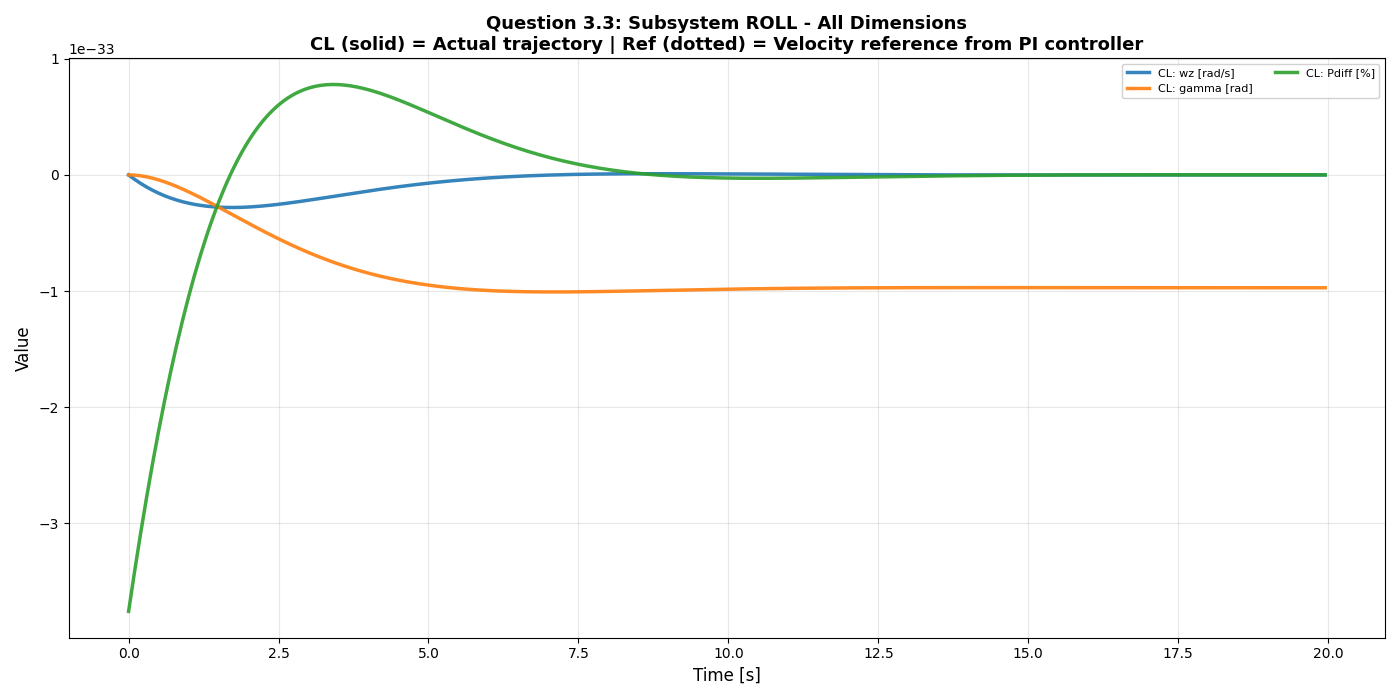

In [55]:
# Question 3.3: Plot Closed Loop (CL) trajectories for each subsystem
# All dimensions (states + input) on the same plot for each subsystem

subsystems_info = [
    {
        'name': 'x',
        'state_indices': [1, 4, 6],  # wy, beta, vx
        'state_names': ['wy', 'beta', 'vx'],
        'state_units': ['rad/s', 'rad', 'm/s'],
        'input_index': 1,  # d2
        'input_name': 'd2',
        'input_unit': 'rad'
    },
    {
        'name': 'y',
        'state_indices': [0, 3, 7],  # wx, alpha, vy
        'state_names': ['wx', 'alpha', 'vy'],
        'state_units': ['rad/s', 'rad', 'm/s'],
        'input_index': 0,  # d1
        'input_name': 'd1',
        'input_unit': 'rad'
    },
    {
        'name': 'z',
        'state_indices': [8],  # vz
        'state_names': ['vz'],
        'state_units': ['m/s'],
        'input_index': 2,  # Pavg
        'input_name': 'Pavg',
        'input_unit': '%'
    },
    {
        'name': 'roll',
        'state_indices': [2, 5],  # wz, gamma
        'state_names': ['wz', 'gamma'],
        'state_units': ['rad/s', 'rad'],
        'input_index': 3,  # Pdiff
        'input_name': 'Pdiff',
        'input_unit': '%'
    }
]

colors_states = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Different colors for each dimension

for sub_info in subsystems_info:
    fig, ax = plt.subplots(1, 1, figsize=(14, 7))
    
    # Plot all states on the same axes
    for idx, (state_idx, state_name, state_unit) in enumerate(zip(sub_info['state_indices'], 
                                                                    sub_info['state_names'], 
                                                                    sub_info['state_units'])):
        color = colors_states[idx % len(colors_states)]
        
        # Closed loop trajectory (actual trajectory) - goes for full sim_time
        ax.plot(t_cl[:-1], x_cl[state_idx, :-1], color=color, linestyle='-', 
               linewidth=2.5, label=f'CL: {state_name} [{state_unit}]', alpha=0.9)
        
        # Plot target/reference if available (from ref which contains velocity references)
        if ref is not None and state_idx in [6, 7, 8]:  # vx, vy, vz are in ref
            ref_idx = state_idx - 6  # Map to ref indices (0, 1, 2)
            if ref_idx < ref.shape[0]:
                ax.plot(t_cl[:-1], ref[ref_idx, :-1], color=color, linestyle=':', 
                      linewidth=2, label=f'Ref: {state_name}', alpha=0.7)
    
    # Plot input on the same axes
    input_idx = sub_info['input_index']
    input_color = colors_states[len(sub_info['state_indices']) % len(colors_states)]
    
    # Closed loop trajectory for input (actual input applied) - goes for full sim_time
    ax.plot(t_cl[:-1], u_cl[input_idx, :], color=input_color, linestyle='-', 
           linewidth=2.5, label=f'CL: {sub_info["input_name"]} [{sub_info["input_unit"]}]', alpha=0.9)
    
    ax.set_xlabel('Time [s]', fontsize=12)
    ax.set_ylabel('Value', fontsize=12)
    ax.set_title(f'Question 3.3: Subsystem {sub_info["name"].upper()} - All Dimensions\n'
                 f'CL (solid) = Actual trajectory | Ref (dotted) = Velocity reference from PI controller',
                 fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=8, ncol=2, framealpha=0.9)
    
    plt.tight_layout()
    plt.show()
